In [35]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.linalg import norm
from scipy.stats import norm, probplot
from scipy.spatial import cKDTree
from geopy.distance import geodesic

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# 1. Import data

This analysis uses Bristol Airbnb listing data to predict rental prices through machine learning techniques. The dataset contains comprehensive information about Airbnb properties including location data, host characteristics, property features, and pricing information. Initial data exploration reveals 75 columns with 2,167 listings after removing entries without price information.

In [36]:
data = pd.read_csv('./input/airbnbs.csv')

In [37]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,20231225202604,2023-12-25,city scrape,Townhouse in Bristol · ★4.77 · 1 bedroom · 1 b...,NaN,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,...,4.94,4.76,4.76,NaN,f,5,0,5,0,1.52
1,117122,https://www.airbnb.com/rooms/117122,20231225202604,2023-12-25,city scrape,Condo in Bristol · ★4.96 · 1 bedroom · 1 bed ·...,NaN,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/13b41142-0946...,591555,...,4.99,4.97,4.88,NaN,f,1,0,1,0,1.18
2,176306,https://www.airbnb.com/rooms/176306,20231225202604,2023-12-25,city scrape,Townhouse in Bristol · ★4.79 · 1 bedroom · 1 b...,NaN,"Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,...,4.94,4.78,4.74,NaN,f,1,0,1,0,0.39


# 2. Date cleaning

First, columns with all missing values and columns with only one unique value are removed as they provide no predictive value. Additionally, listings without price information are excluded from the analysis, ensuring all remaining entries have the target variable available. This preprocessing reduces the dataset to 67 meaningful columns while maintaining data integrity.

In [38]:
# remove meaningless columns
data = data.dropna(axis=1, how='all')

unique_counts = data.nunique()

data = data.loc[:, unique_counts > 1]

In [39]:
# delect the rows without price
data = data.dropna(subset=['price'])

In [40]:
data.head(3)

,id,listing_url,last_scraped,source,name,neighborhood_overview,picture_url,host_id,host_url,host_name,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,2023-12-25,city scrape,Townhouse in Bristol · ★4.77 · 1 bedroom · 1 b...,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,https://www.airbnb.com/users/show/360195,Sarah,...,4.95,4.94,4.76,4.76,f,5,0,5,0,1.52
1,117122,https://www.airbnb.com/rooms/117122,2023-12-25,city scrape,Condo in Bristol · ★4.96 · 1 bedroom · 1 bed ·...,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/13b41142-0946...,591555,https://www.airbnb.com/users/show/591555,Marcus,...,5.00,4.99,4.97,4.88,f,1,0,1,0,1.18
2,176306,https://www.airbnb.com/rooms/176306,2023-12-25,city scrape,Townhouse in Bristol · ★4.79 · 1 bedroom · 1 b...,"Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,https://www.airbnb.com/users/show/708175,Orla,...,4.98,4.94,4.78,4.74,f,1,0,1,0,0.39


In [41]:
column_names = data.columns
print(column_names)

Index(['id', 'listing_url', 'last_scraped', 'source', 'name',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
    

# 3. Basic Features Choosing

Feature selection focuses on variables most relevant to price prediction, including geographic coordinates (latitude, longitude), neighborhood information, host characteristics, property specifications, and review metrics. Key features include property type, room type, number of beds and bathrooms, accommodation capacity, minimum nights requirement, review scores across multiple dimensions, and calculated host listing counts.

In [42]:
data_need = data[['latitude', 'longitude','neighbourhood_cleansed','host_is_superhost', 'property_type', 'room_type', 'bathrooms_text', 'beds', 'minimum_nights',
'number_of_reviews', 'number_of_reviews_ltm', 'last_review', 'first_review',
'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value', 'instant_bookable', 'reviews_per_month', 'calculated_host_listings_count',
'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
'calculated_host_listings_count_shared_rooms','accommodates', 'price']]

# 4. Preprocessing 'Price' vlaue

Target value 'Pirce' initial analysis reveals severe right skewness (4.23) and high kurtosis (25.45), indicating non-normal distribution with extreme outliers. Outliers above $2,000 are removed to reduce noise. Subsequently, log transformation (log1p) is applied to normalize the distribution, resulting in substantially improved skewness (0.48) and kurtosis (0.65), making the target variable more suitable for regression modeling.

In [43]:
data_need['price'] = data_need['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

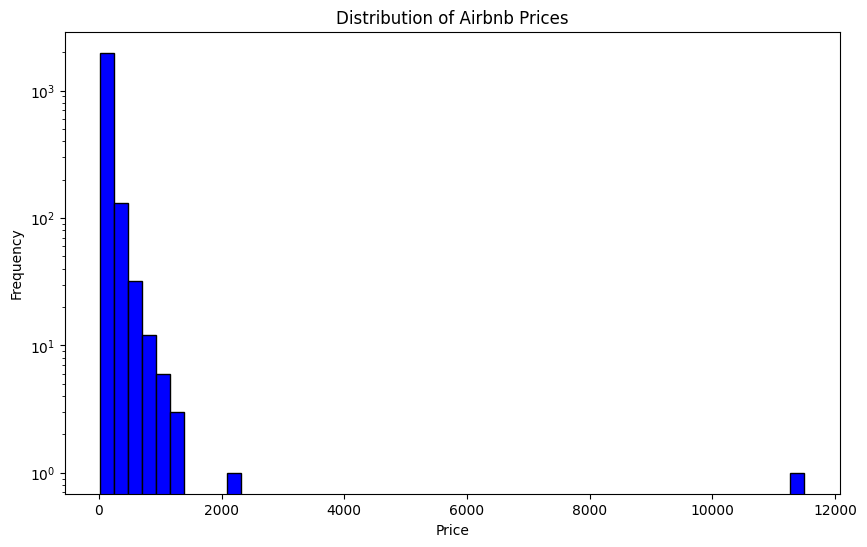

In [44]:
# change to boxplot
plt.figure(figsize=(10, 6))
plt.hist(data_need['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.yscale('log')  # Using a log scale for better visualization of the distribution
plt.show()

In [45]:
data_need = data_need.drop(data_need[data_need['price'] > 2000].index)

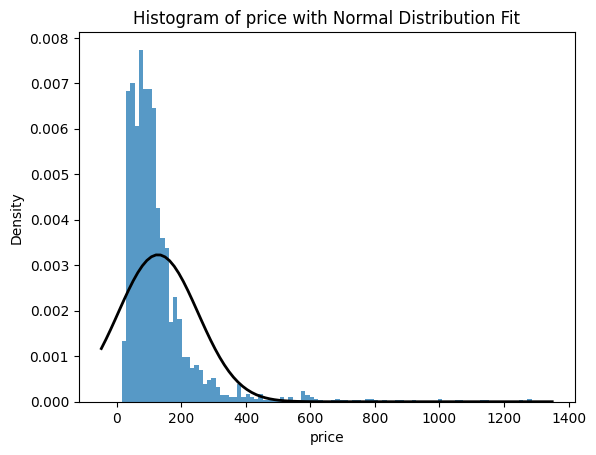

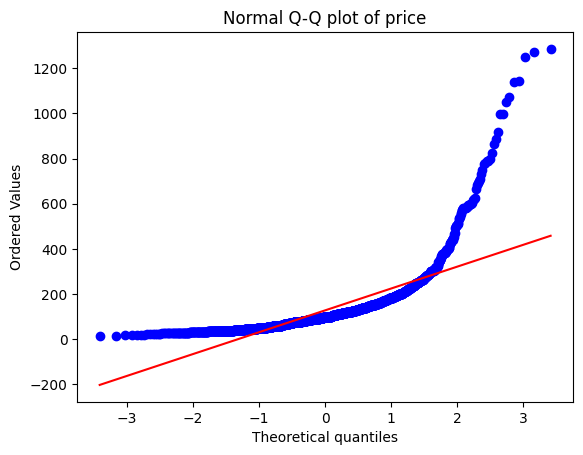

Skewness: 4.228017
Kurtosis: 25.451396


In [46]:
# Draw a histogram and fit a normal distribution curve
sns.histplot(data_need['price'], kde=False, stat="density", linewidth=0)
plt.xlabel('price')
plt.ylabel('Density')
plt.title('Histogram of price with Normal Distribution Fit')

# Overlay a normal distribution curve on the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data_need['price'].mean(), data_need['price'].std())
plt.plot(x, p, 'k', linewidth=2)

plt.show()

fig = plt.figure()
res = probplot(data_need['price'], plot=plt)
plt.title('Normal Q-Q plot of price')
plt.show()

print("Skewness: %f" % data_need['price'].skew())
print("Kurtosis: %f" % data_need['price'].kurt())

In [47]:
data_need['log_price'] = np.log1p(data_need['price'])

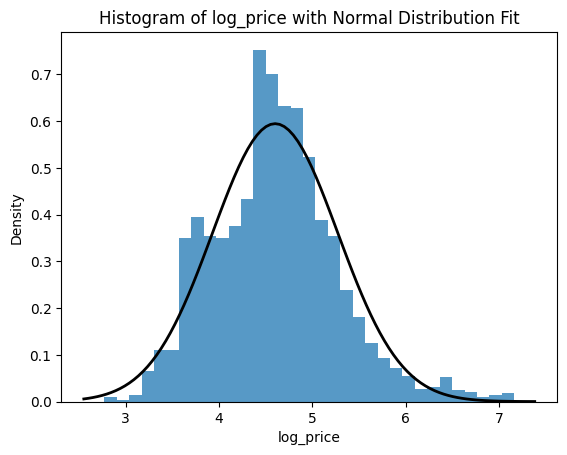

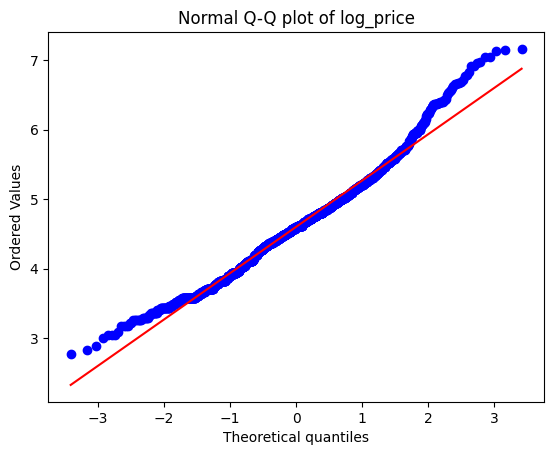

Skewness: 0.477380
Kurtosis: 0.648204


In [48]:
# Draw a histogram and fit a normal distribution curve
sns.histplot(data_need['log_price'], kde=False, stat="density", linewidth=0)
plt.xlabel('log_price')
plt.ylabel('Density')
plt.title('Histogram of log_price with Normal Distribution Fit')

# Overlay a normal distribution curve on the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data_need['log_price'].mean(), data_need['log_price'].std())
plt.plot(x, p, 'k', linewidth=2)

plt.show()

# Draw a normal probability plot
fig = plt.figure()
res = probplot(data_need['log_price'], plot=plt)
plt.title('Normal Q-Q plot of log_price')
plt.show()

# Calculate the skewness and kurtosis after transformation
print("Skewness: %f" % data_need['log_price'].skew())
print("Kurtosis: %f" % data_need['log_price'].kurt())

# 5. Preprocessing Features

Feature engineering involves multiple transformations to optimize data for machine learning. Property types are grouped into broader categories (Entire Home, Entire Apartment, Private Room, etc.) to reduce dimensionality. Bathroom information is parsed using regex to extract separate counts for shared and private bathrooms. Rating and bedroom information are extracted from listing names using pattern matching. Date variables are converted to temporal features measuring days since first and last reviews. Missing values are handled through median imputation for numerical features and mode imputation for categorical variables. Finally, categorical variables are label-encoded for model compatibility.

In [49]:
pd.set_option('display.max_rows', None)
data_need.agg(['unique']).transpose()

,unique
latitude,"[51.43843, 51.44976, 51.44174, 51.46487, 51.44..."
longitude,"[-2.59183, -2.61, -2.60297, -2.5569, -2.55783,..."
neighbourhood_cleansed,"[Windmill Hill, Hotwells & Harbourside, Southv..."
host_is_superhost,"[f, t, nan]"
property_type,"[Private room in townhouse, Private room in co..."
room_type,"[Private room, Entire home/apt, Hotel room, Sh..."
bathrooms_text,"[1 shared bath, 2.5 shared baths, 1.5 shared b..."
beds,"[1.0, 2.0, 3.0, 4.0, 6.0, nan, 5.0, 8.0, 14.0,..."
minimum_nights,"[3, 1, 5, 6, 2, 4, 7, 20, 90, 30, 10, 12, 28, ..."
number_of_reviews,"[189, 180, 53, 34, 59, 84, 101, 330, 194, 436,..."


In [50]:
dict1 = {'Entire Home': ['Entire home', 'Entire townhouse', 'Entire guesthouse', 'Entire cottage', 
                    'Entire villa', 'Entire vacation home', 'Entire bungalow', 'Entire cabin', 
                    'Entire loft'],
        'Entire Apartment': ['Entire rental unit', 'Entire condo', 'Entire serviced apartment', 
                         'Entire guest suite'],
    'Private Room': ['Private room in home', 'Private room in rental unit', 'Private room in townhouse', 
                     'Private room in condo', 'Private room in bed and breakfast', 'Private room', 
                     'Private room in guest suite', 'Private room in tiny home', 'Private room in guesthouse', 
                     'Private room in loft', 'Private room in serviced apartment', 'Private room in hostel', 
                     'Private room in camper/rv', 'Private room in cabin', 'Private room in yurt', 
                     'Private room in hut', 'Private room in castle', 'Private room in casa particular', 
                     'Private room in bungalow'],
    'Shared Room': ['Shared room in rental unit', 'Shared room in home'],
    'Hotel Room': ['Room in serviced apartment', 'Room in hotel', 'Room in boutique hotel', 
                   'Room in aparthotel'],
    'Other': ['Tiny home', 'Camper/RV', 'Treehouse', 'Barn', 'Houseboat', 'Religious building']
        }

# Reverse the mapping
dict2 = {i: k for k, v in dict1.items() for i in v}

data_need = data_need.copy()

# Replace and calculate
data_need['property_type_group'] = data_need['property_type'].replace(dict2)
print(data_need['property_type_group'].value_counts())

property_type_group
Entire Apartment    983
Private Room        644
Entire Home         488
Other                29
Hotel Room           16
Entire place          4
Shared Room           3
Name: count, dtype: int64


In [51]:
# split bathroom_text
def extract_bath_info(bathrooms_text):
    if pd.isna(bathrooms_text):
        return pd.Series([0, 0])
    
    bath_count = 0
    shared_bath_count = 0
    
    if 'half' in bathrooms_text.lower():
        return pd.Series([shared_bath_count, bath_count])
    
    match = re.match(r'(\d*\.?\d*)\s?(shared|private)?\s?bath(s)?', bathrooms_text.lower())
    if match:
        bath_count = float(match.group(1)) if match.group(1) else 0
        if match.group(2) == 'shared':
            shared_bath_count = bath_count
            bath_count = 0

    return pd.Series([shared_bath_count, bath_count])

data_need = data_need.copy()

data_need[['shared_bath_count', 'bath_count']] = data_need['bathrooms_text'].apply(extract_bath_info)

print(data_need[['bathrooms_text', 'shared_bath_count', 'bath_count']].head(10))

     bathrooms_text  shared_bath_count  bath_count
0     1 shared bath                1.0         0.0
1  2.5 shared baths                2.5         0.0
2     1 shared bath                1.0         0.0
3  1.5 shared baths                1.5         0.0
4     1 shared bath                1.0         0.0
5     1 shared bath                1.0         0.0
6    1 private bath                0.0         1.0
7            1 bath                0.0         1.0
8    1 private bath                0.0         1.0
9           2 baths                0.0         2.0


In [52]:
def extract_info(name):
    rating = re.search(r'★(\d\.\d+)', name)
    rating = rating.group(1) if rating else None  # 提取数字部分

    bedroom = re.search(r'(\d+) bedrooms?', name)
    bedroom = bedroom.group(1) if bedroom else None  # 提取数字部分

    return pd.Series([rating, bedroom])

data_need = data_need.copy()

data_need[['rating', 'bedroom']] = data['name'].apply(extract_info)

data_need.head(3)

,latitude,longitude,neighbourhood_cleansed,host_is_superhost,property_type,room_type,bathrooms_text,beds,minimum_nights,number_of_reviews,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,accommodates,price,log_price,property_type_group,shared_bath_count,bath_count,rating,bedroom
0,51.43843,-2.59183,Windmill Hill,f,Private room in townhouse,Private room,1 shared bath,1.0,3,189,...,5,0,2,44.0,3.806662,Private Room,1.0,0.0,4.77,1
1,51.44976,-2.61000,Hotwells & Harbourside,t,Private room in condo,Private room,2.5 shared baths,1.0,1,180,...,1,0,2,111.0,4.718499,Private Room,2.5,0.0,4.96,1
2,51.44174,-2.60297,Southville,t,Private room in townhouse,Private room,1 shared bath,1.0,5,53,...,1,0,2,35.0,3.583519,Private Room,1.0,0.0,4.79,1


In [53]:
data_need = data_need.drop(columns=['bathrooms_text', 'property_type'])

In [54]:
pd.set_option('display.max_rows', None)
data_need.agg(['unique']).transpose()

,unique
latitude,"[51.43843, 51.44976, 51.44174, 51.46487, 51.44..."
longitude,"[-2.59183, -2.61, -2.60297, -2.5569, -2.55783,..."
neighbourhood_cleansed,"[Windmill Hill, Hotwells & Harbourside, Southv..."
host_is_superhost,"[f, t, nan]"
room_type,"[Private room, Entire home/apt, Hotel room, Sh..."
beds,"[1.0, 2.0, 3.0, 4.0, 6.0, nan, 5.0, 8.0, 14.0,..."
minimum_nights,"[3, 1, 5, 6, 2, 4, 7, 20, 90, 30, 10, 12, 28, ..."
number_of_reviews,"[189, 180, 53, 34, 59, 84, 101, 330, 194, 436,..."
number_of_reviews_ltm,"[11, 9, 10, 3, 8, 12, 18, 4, 42, 43, 23, 45, 3..."
last_review,"[2023-11-29, 2023-11-26, 2023-12-12, 2023-12-2..."


In [55]:
data_need.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2167 entries, 0 to 2555
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   latitude                                      2167 non-null   float64
 1   longitude                                     2167 non-null   float64
 2   neighbourhood_cleansed                        2167 non-null   object 
 3   host_is_superhost                             2165 non-null   object 
 4   room_type                                     2167 non-null   object 
 5   beds                                          2119 non-null   float64
 6   minimum_nights                                2167 non-null   int64  
 7   number_of_reviews                             2167 non-null   int64  
 8   number_of_reviews_ltm                         2167 non-null   int64  
 9   last_review                                   1887 non-null   object

In [56]:
data_need.shape

(2167, 32)

# 6. Data Training

The modeling approach employs Gradient Boosting Regressor, selected for its effectiveness with structured data and robustness to feature scaling differences. The dataset is split 80/20 for training and validation with StandardScaler normalization applied to ensure feature comparability. Initial model performance achieves promising results with training R² of 0.828 and validation R² of 0.760, indicating good predictive capability while maintaining reasonable bias-variance balance.

In [57]:
# Before adding the log_price column, check for missing values ​​in the original price column
missing_price_count = data_need['price'].isnull().sum()
print(f'Number of missing values in price: {missing_price_count}')

Number of missing values in price: 0


In [58]:
# Handling missing values
data_clean = data_need.copy()

# Fill missing values
data_clean['beds'].fillna(data_clean['beds'].median(), inplace=True)
data_clean['review_scores_rating'].fillna(data_clean['review_scores_rating'].median(), inplace=True)
data_clean['review_scores_accuracy'].fillna(data_clean['review_scores_accuracy'].median(), inplace=True)
data_clean['review_scores_cleanliness'].fillna(data_clean['review_scores_cleanliness'].median(), inplace=True)
data_clean['review_scores_checkin'].fillna(data_clean['review_scores_checkin'].median(), inplace=True)
data_clean['review_scores_communication'].fillna(data_clean['review_scores_communication'].median(), inplace=True)
data_clean['review_scores_location'].fillna(data_clean['review_scores_location'].median(), inplace=True)
data_clean['review_scores_value'].fillna(data_clean['review_scores_value'].median(), inplace=True)
data_clean['reviews_per_month'].fillna(data_clean['reviews_per_month'].median(), inplace=True)

# Fill missing values ​​of categories
data_clean['host_is_superhost'].fillna('f', inplace=True)
data_clean['bedroom'].fillna(data_clean['bedroom'].mode()[0], inplace=True)


data_clean['last_review'] = pd.to_datetime(data_clean['last_review'])
data_clean['first_review'] = pd.to_datetime(data_clean['first_review'])

# Processing date variables
data_clean['days_since_last_review'] = (data_clean['last_review'].max() - data_clean['last_review']).dt.days
data_clean['days_since_first_review'] = (data_clean['last_review'] - data_clean['first_review']).dt.days

# Delete the original date column
data_clean.drop(columns=['last_review', 'first_review'], inplace=True)

# Fill missing values ​​for date differences
data_clean['days_since_last_review'].fillna(data_clean['days_since_last_review'].median(), inplace=True)
data_clean['days_since_first_review'].fillna(data_clean['days_since_first_review'].median(), inplace=True)

# Process the rating column
data_clean['rating'] = pd.to_numeric(data_clean['rating'], errors='coerce')
data_clean['rating'].fillna(data_clean['rating'].median(), inplace=True)

# Process the bedroom column (if it is an object)
data_clean['bedroom'] = pd.to_numeric(data_clean['bedroom'], errors='coerce')
data_clean['bedroom'].fillna(data_clean['bedroom'].median(), inplace=True)

In [59]:
# Before adding the log_price column, check for missing values ​​in the original price column
missing_price_count = data_clean['price'].isnull().sum()
print(f'Number of missing values in price: {missing_price_count}')

Number of missing values in price: 0


In [60]:
# Use LabelEncoder to encode categorical variables
categorical_columns = ['neighbourhood_cleansed', 'host_is_superhost', 'room_type', 'instant_bookable', 'property_type_group']
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    data_clean[column] = le.fit_transform(data_clean[column])
    label_encoders[column] = le

# Delete the original price column
data_clean.drop(columns=['price'], inplace=True)

In [61]:
data_clean.head(3).T

,0,1,2
latitude,51.438430,51.449760,51.441740
longitude,-2.591830,-2.610000,-2.602970
neighbourhood_cleansed,33.000000,20.000000,26.000000
host_is_superhost,0.000000,1.000000,1.000000
room_type,2.000000,2.000000,2.000000
beds,1.000000,1.000000,1.000000
minimum_nights,3.000000,1.000000,5.000000
number_of_reviews,189.000000,180.000000,53.000000
number_of_reviews_ltm,11.000000,9.000000,10.000000
review_scores_rating,4.770000,4.960000,4.790000


In [62]:
data_clean.shape

(2167, 31)

In [63]:
# Split the dataset
X = data_clean.drop(columns=['log_price'])
y = data_clean['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Build a random forest model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Predict training set and validation set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the MSE of the training set and the validation set
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate R² for training and validation sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

Training MSE: 0.01816901370651347
Test MSE: 0.12201282632650615
Training R²: 0.9595397789606408
Test R²: 0.7306116247887489


In [64]:
# Split the dataset
X = data_clean.drop(columns=['log_price'])
y = data_clean['log_price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Run the model Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# predict
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

# Print MSE and R² for training and validation sets
print("\nTraining MSE:", round(mean_squared_error(y_train, pred_train), 4))
print("Validation MSE:", round(mean_squared_error(y_val, pred_val), 4))
print("\nTraining r2:", round(r2_score(y_train, pred_train), 4))
print("Validation r2:", round(r2_score(y_val, pred_val), 4))


Training MSE: 0.0772
Validation MSE: 0.1086

Training r2: 0.828
Validation r2: 0.7601


# 7. Introducing Spatial Features

Spatial feature engineering significantly enhances model performance through location-based variables. Using cKDTree for efficient spatial queries, three key features are created: (1) count of nearby Airbnb listings within 150 meters, (2) average log price of properties in the same 150-meter radius, and (3) distance to Bristol city center calculated using geodesic distance. These spatial features capture local market dynamics and location desirability effects. The enhanced model demonstrates substantial improvement with validation R² increasing from 0.760 to 0.808, validating the importance of spatial context in short-term rental pricing.

In [65]:
# add new features
from geopy.distance import geodesic
from scipy.spatial import cKDTree

# Calculate the number of objects within 150 meters of each point and the average log_price
coords = data_clean[['latitude', 'longitude']].values
tree = cKDTree(coords)
dists, indices = tree.query(coords, k=len(coords), distance_upper_bound=0.15/111)  # 0.15 km is approximately 150 meters

# Fix indexing issues
valid_indices = [idx[idx < len(coords)] for idx in indices]
point_150m = np.array([len(vi) - 1 for vi in valid_indices])  # exclude the point itself

logprice_150m = []
for vi in valid_indices:
    if len(vi) > 1:
        logprice_150m.append(data_clean.iloc[vi]['log_price'].mean())
    else:
        logprice_150m.append(np.nan)

data_clean['point_150m'] = point_150m
data_clean['logprice_150m'] = logprice_150m

# Fill missing values ​​in logprice_150m
overall_logprice_mean = data_clean['log_price'].mean()
data_clean['logprice_150m'].fillna(overall_logprice_mean, inplace=True)

# Calculate the distance from the city center
city_center = (51.4538, -2.5918)
data_clean['distance_center'] = data_clean.apply(lambda row: geodesic((row['latitude'], row['longitude']), city_center).km, axis=1)


In [66]:
data_clean.head(3).T

,0,1,2
latitude,51.438430,51.449760,51.441740
longitude,-2.591830,-2.610000,-2.602970
neighbourhood_cleansed,33.000000,20.000000,26.000000
host_is_superhost,0.000000,1.000000,1.000000
room_type,2.000000,2.000000,2.000000
beds,1.000000,1.000000,1.000000
minimum_nights,3.000000,1.000000,5.000000
number_of_reviews,189.000000,180.000000,53.000000
number_of_reviews_ltm,11.000000,9.000000,10.000000
review_scores_rating,4.770000,4.960000,4.790000


In [67]:
# Split the dataset
X = data_clean.drop(columns=['log_price'])
y = data_clean['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling using GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(X_train, y_train)

# Predict training and test sets
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

# Calculate MSE and R² for training and test sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Training R²: {train_r2}')
print(f'Test R²: {test_r2}')

Training MSE: 0.06394135316408885
Test MSE: 0.08691647083544968
Training R²: 0.8576102520277524
Test R²: 0.8080997911252273
